In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Attribution Trickiness and DeepLiftShap Implementations

A common use-case of a trained sequence-based model is better understanding biological sequences through attributions. At a high level, attributions highlight portions of the sequence that drive a model's predictions. So, if the model predicts that a protein will bind to a particular sequence, attributions can highlight the specific nucleotides that drive that binding. There are several different ways to calculate attributions that each have different theoretical properties.

One of these, DeepLIFT/SHAP, is a conceptually simple algorithm: calculate the gradient of the input data with respect to the model parameters, but override the gradient calculation to overcome the saturation effect seen in models, and have this gradient be calculated on the difference between the observed sequence and some reference sequence where model predictions are meant to be low. I will leave the details of how this works to the paper and other tangermeme tutorial but, put simply, this overriding of the gradient calculation becomes an implementation issue because *not all operations are overridden, only non-linear ones* and the most common way to have PyTorch know whether an operation is non-linear is by keeping a dictionary of operations to override. This detail is hidden in most implementations and means that any custom layers that have non-linear functions -- and even built-in layers that simply are not in this dictionary -- will not be overriden and will cause the resulting attributions to be incorrect.

##### Summation-to-Delta

A key property of the DeepLIFT/SHAP algorithm is summation-to-delta. Basically, this means that the sum of the attribution scores (multiplied by the difference between the observed sequence and the reference) is equal to the difference between model predictions on the observed sequence and on the reference sequence (the delta). Written out, given a model $f$, an observed sequence $X$ of length $L_s$ and alphabet size $L_a$, a reference sequence $X^r$ of the same size, and attributions $A$:

\begin{equation}
    \sum_{i=0}^{L_s} \sum_{j=0}^{L_a} A_{ij}(X_{ij} - X^r_{ij}) = f(X) - f(X_b)
\end{equation}

In words, the *sum* of the attributions (multiplied by difference in sequence) is equal to the *delta* of model predictions. Alternatively, this sum minus the delta should be equal to zero. In practice, this difference likely just *close* to zero due to machine precision issues. This property will be extremely important because when DeepLIFT/SHAP is implemented incorrectly it will no longer hold. 

##### GATA2 BPNet

To investigate this, let's use a BPNet model trained to predict GATA2 binding. For those who have not heard of it, BPNet is a convolutional neural network that takes in 2114 bp sequences and predicts (1) mapped read probabilities for each bp in a 1kb output region and (2) the total log count for that region. As we will see, BPNet models are ideal for investigating the issues with DeepLIFT/SHAP because calculating attributions on the count head is usually simple and works out-of-the-box and calculating attributions on the profile head is a pain.

Let's begin by loading a pre-trained model. We will wrap this in a `ControlWrapper` object which just automatically feeds in all zeroes for the control track. This detail does not matter for this vignette. 

In [2]:
import torch
from bpnetlite.bpnet import ControlWrapper

model = ControlWrapper(torch.load("gata2.bpnet.torch", map_location='cpu'))

Attribution algorithms usually only "explain" one output at a time (the $f(X)$ in the equation above). For the count head, we are just calculating attributions using the predicted counts, which is a single number per example. The profile head is more complicated because we get 1,000 numbers: one per basepair. To convert this profile into a single number we take the dot product between the predicted logits (not the probabilities) and the post-softmax probabilities. This can be thought of as a weight on the logits that accounts for their relative value.

\begin{equation}
    A_p = f(X) \cdot softmax(f(X))
\end{equation}

To get these, we will use one wrapper that simply extracts the count value (`CountWrapper`) and one that extracts the profile output and performs the above dot product (`ProfileWrapper`). Both return a single number for each sequence but use separate outputs to do so.

In [3]:
from bpnetlite.bpnet import CountWrapper
from bpnetlite.bpnet import ProfileWrapper

wrapper_counts = CountWrapper(model)
wrapper_profile = ProfileWrapper(model)

##### DeepLiftShap on the Count Head

Before beginning this section, let me reiterate that the following issues are not BPNet-specific. Any model architecture with non-standard components (and even some some using specific built-in components!) will encounter these issues, but BPNet models are a convenient way to demonstrate the issues. 

With that out of the way, let's generate a random sequence and put a high-affinity GATA2 motif into the middle. 

In [4]:
from tangermeme.utils import random_one_hot
from tangermeme.ersatz import substitute

X = random_one_hot((1, 4, 2114), random_state=0).type(torch.float32)
X = substitute(X, "AGATAAG")

DeepLIFT/SHAP requires reference sequences when calculating attributions. We can generate those by dinucleotide shuffling the sequence. `tangermeme` has this aspect built-in so you don't need to shuffle the sequence yourself, but when we compare across implementatons we want to use the same references to make sure there is no randomness in the results.

In [5]:
from tangermeme.ersatz import dinucleotide_shuffle

X_ref = dinucleotide_shuffle(X, n=20, random_state=0)

Now, we will calculate the DeepLIFT/SHAP attributions using tangermeme and using Captum. Ignore `hypothetical_attributions` for now -- we will cover it later.

In [6]:
from captum.attr import DeepLiftShap
from tangermeme.deep_lift_shap import deep_lift_shap
from tangermeme.deep_lift_shap import hypothetical_attributions

X_attr_t = deep_lift_shap(wrapper_counts, X, references=X_ref, device='cpu')
X_attr_c = DeepLiftShap(wrapper_counts).attribute(X, X_ref[0], custom_attribution_func=hypothetical_attributions).detach() * X

/users/jmschr/anaconda3/lib/python3.11/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


These implementations provide attributions that are averaged across references. Usually, one only cares about the attributions for observed characters, so you multiply by the observed one-hot sequence. `tangermeme` does this by default, but Captum does not, hence the multiplication.

We can visually inspect the attributions by just plotting them.

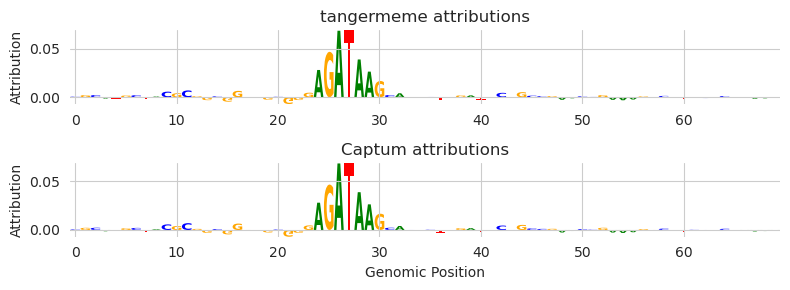

In [7]:
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
from tangermeme.plot import plot_logo

plt.figure(figsize=(8, 3))
ax = plt.subplot(211)
plt.title("tangermeme attributions")
plot_logo(X_attr_t[0], ax=ax, start=1030, end=1100)
plt.ylabel("Attribution")

ax = plt.subplot(212)
plt.title("Captum attributions")
plot_logo(X_attr_c[0], ax=ax, start=1030, end=1100)
plt.xlabel("Genomic Position")
plt.ylabel("Attribution")

plt.tight_layout()
plt.show()

More systematically, we can veryify that the two implementations yield identical attributions using a scatterplot of the values.

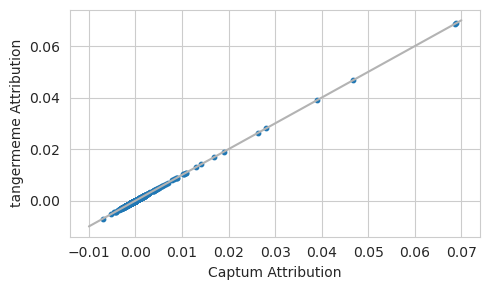

In [8]:
plt.figure(figsize=(5, 3))
plt.scatter(X_attr_c.flatten(), X_attr_t.flatten(), s=10)
plt.plot([-0.01, 0.07], [-0.01, 0.07], c='0.7')
plt.xlabel("Captum Attribution")
plt.ylabel("tangermeme Attribution")
plt.tight_layout()
plt.show()

#### Convergence deltas must be calculated before aggregating multipliers

So far, everything looks good, so it's time to check the convergence deltas. In both implementations, the convergence deltas are the difference between the sum of the attribution values and the difference between the predicted values. This terminology is sort of confusing because one could think of $f(X) - f(X^r)$ as a delta, but also think of the difference between both sides of the equation at the top of this notebook as a delta. To be clear, the convergence deltas here are $\delta = \sum_{i=0}^{L_s} \sum_{j=0}^{L_a} A_{ij}(X_{ij} - X^r_{ij}) - (f(X) - f(X_b))$.

We can get the convergence deltas from `tangermeme` using the `print_convergence_deltas` parameter. This will print the convergence deltas for each example-reference pair that goes through the DeepLIFT/SHAP algorithm. Similarly, we can use the `return_convergence_delta` parameter to get them for Captum.

In [9]:
print("tangermeme convergence deltas")
deep_lift_shap(wrapper_counts, X, references=X_ref, device='cpu', print_convergence_deltas=True)

_, deltas_c = DeepLiftShap(wrapper_counts).attribute(X, X_ref[0], return_convergence_delta=True, 
    custom_attribution_func=hypothetical_attributions)

print("\nCaptum convergence deltas")
print(deltas_c)

tangermeme convergence deltas
tensor([0.0000e+00, 8.9407e-08, 1.6391e-07, 1.4901e-07, 5.9605e-08, 8.9407e-08,
        2.9802e-08, 2.9802e-08, 7.4506e-08, 5.9605e-08, 8.9407e-08, 5.9605e-08,
        1.4901e-08, 2.2352e-08, 0.0000e+00, 5.9605e-08, 5.9605e-08, 1.7881e-07,
        1.0431e-07, 5.9605e-08], grad_fn=<AbsBackward0>)


/users/jmschr/anaconda3/lib/python3.11/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(



Captum convergence deltas
tensor([-2.8115, -2.4892, -2.7869, -3.7164, -3.4582, -2.4587, -2.9038, -2.2653,
        -3.3003, -2.5556, -2.5912, -3.7841, -2.3939, -3.4029, -2.2987, -2.9450,
        -2.8853, -3.0373, -3.0079, -2.4492])


The tangermeme ones look good and near machine precision -- but the Captum ones look super high! How did that happen? Especially when we just saw that tangermeme and Captum gave us the same results?

Well, the problem is that `hypothetical_attributions` function I pointed out before. Basically, DeepLIFT/SHAP by itself will return multipliers on each character and position in the sequence. However, because discrete sequences have the structure that the presence of one character means explicitly not other characters, the multipliers have to be corrected using the `hypothetical_attributions` function. I will leave the details for another tutorial but this is a desirable correction to do. 

*However*, once `hypothetical_attributions` is applied the summation-to-delta property will *no longer hold*. Because Captum's implementation applies custom functions *before* calculating the convergence deltas, this makes the `return_convergence_delta` parameter not valuable for our applications.

We will have to calculate the convergences ourselves. Let's start off by calculating the post-`hypothetical_attributions` values for both tangermeme and Captum.

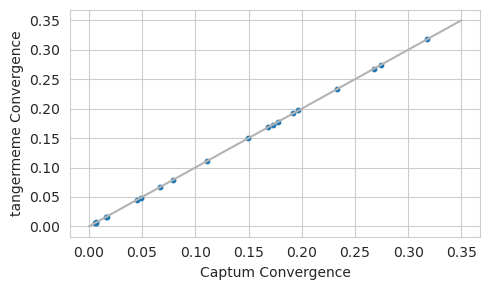

In [10]:
y, y_ref = wrapper_counts(X), wrapper_counts(X_ref[0])

output_diff = (y - y_ref)[:, 0]
input_diff = (X - X_ref[0])

convergence_t = abs(output_diff - torch.sum(input_diff * X_attr_t, dim=(1, 2))).numpy(force=True)
convergence_c = abs(output_diff - torch.sum(input_diff * X_attr_c, dim=(1, 2))).numpy(force=True)

plt.figure(figsize=(5, 3))
plt.scatter(convergence_c, convergence_t, s=10)
plt.plot([0, 0.35], [0, 0.35], c='0.7')
plt.xlabel("Captum Convergence")
plt.ylabel("tangermeme Convergence")
plt.tight_layout()
plt.show()

Okay, looks like they match here. But remember that we want the pre-`hypothetical_attributions` attributions to be almost zero. We can check this by just skipping the `hypothetical_attributions` step to confirm.

In [11]:
DeepLiftShap(wrapper_counts).attribute(X, X_ref[0], return_convergence_delta=True)[1]

tensor([-2.9802e-08, -1.1921e-07,  1.6391e-07,  1.3039e-07,  2.9802e-08,
        -5.9605e-08,  2.9802e-08,  0.0000e+00,  1.3411e-07, -2.9802e-08,
        -1.1921e-07,  7.4506e-08, -2.9802e-08,  3.7253e-08,  2.9802e-08,
        -5.9605e-08,  7.4506e-08, -2.0862e-07, -1.2666e-07, -2.9802e-08])

Great! We have confirmed now that tangermeme and Captum yield identical attributions on the count head and that both implementations have small convergence deltas. Further, we have found that just naively using `return_convergence_delta` will not yield meaningful values for the Captum implementation.

Can we just calculate the convergence deltas ourselves in the same way these packages are? Sure! For tangermeme, we just need to set `hypothetical=True` so that it doesn't multiply the sequence by the one-hot encoding and `raw_outputs=True` to get the raw multipliers instead of applying `hypothetical_attributions`. For `Captum` we just need to set `multiply_by_inputs=False` and not feed a custom function in.

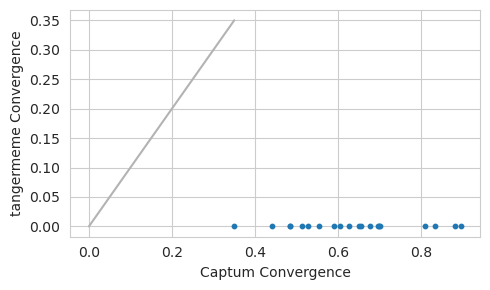

In [12]:
X_attr_t = deep_lift_shap(wrapper_counts, X, references=X_ref, device='cpu', hypothetical=True, raw_outputs=True)
X_attr_c = DeepLiftShap(wrapper_counts, multiply_by_inputs=False).attribute(X, X_ref[0]).detach()

convergence_t = abs(output_diff - torch.sum(input_diff * X_attr_t[0], dim=(1, 2))).numpy(force=True)
convergence_c = abs(output_diff - torch.sum(input_diff * X_attr_c, dim=(1, 2))).numpy(force=True)

plt.figure(figsize=(5, 3))
plt.scatter(convergence_c, convergence_t, s=10)
plt.plot([0, 0.35], [0, 0.35], c='0.7')
plt.xlabel("Captum Convergence")
plt.ylabel("tangermeme Convergence")
plt.tight_layout()
plt.show()

Oh, wait. What happened here? It looks like tangermeme's convergence deltas have become zeros but the Captum convergence deltas are even higher in magnitude than before. This bump in the road happened because we need to operate on each example-reference pair individually but Captum will, without a choice not to, average over all references. Even when we aren't applying the `hypothetical_attributions` function we are still getting a value that cannot be used to calculate the convergence deltas.

So, at this point, we (1) cannot rely on Captum's built-in convergence delta calculator when we need to correct the multipliers and (2) we cannot calculate the convergence deltas ourselves because the only returned values process the data in a way that cannot be undone.

To show what would happen if we *could* get the per-example values, let's create a new set of references that are just the first reference copied 20 times. In theory we could just pass in a single reference but then Captum will complain because their `DeepLiftShap` implementation assumes at least two references.

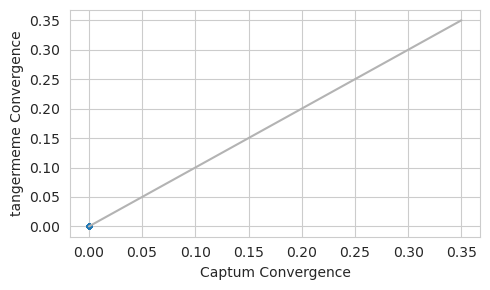

In [13]:
X_ref2 = X_ref[:, 0].repeat(1, 20, 1, 1)
y_ref2 = wrapper_counts(X_ref2[0])

output_diff = (y - y_ref2)[:, 0]
input_diff = (X - X_ref2[0])

X_attr_t = deep_lift_shap(wrapper_counts, X, references=X_ref2, device='cpu', hypothetical=True, raw_outputs=True)
X_attr_c = DeepLiftShap(wrapper_counts, multiply_by_inputs=False).attribute(X, X_ref2[0]).detach()

convergence_t = abs(output_diff - torch.sum(input_diff * X_attr_t[0], dim=(1, 2))).numpy(force=True)
convergence_c = abs(output_diff - torch.sum(input_diff * X_attr_c, dim=(1, 2))).numpy(force=True)

plt.figure(figsize=(5, 3))
plt.scatter(convergence_c, convergence_t, s=10)
plt.plot([0, 0.35], [0, 0.35], c='0.7')
plt.xlabel("Captum Convergence")
plt.ylabel("tangermeme Convergence")
plt.tight_layout()
plt.show()

Okay, great. We can see that when not using `hypothetical_attributions` we get convergence deltas that are near zero for both implementations. But the bigger point here is that, even for the simpler case (using the count head) things can be more difficult than one might initially expect! This is why tangermeme tries to minimize these issues by automatically calculating the convergence deltas before any custom function is applied.

##### Custom non-linear layers must be registered

Now, let's turn to the more challenging case: the profile head. You will know that something is up immediately when using tangermeme because this is what you get when you try to run the `deep_lift_shap` function using the profile wrapper.

In [14]:
X_attr_t1 = deep_lift_shap(wrapper_profile, X, references=X_ref, device='cpu')

/users/jmschr/github/tangermeme/tangermeme/deep_lift_shap.py:436: RuntimeWarning: Convergence deltas too high: tensor([0.7880, 0.8378, 0.8066, 0.6598, 0.8300, 0.8763, 1.2753, 0.9891, 1.4031,
        0.8181, 0.8182, 0.7865, 0.8997, 0.6959, 0.9951, 0.8051, 1.0015, 1.0880,
        0.8774, 0.7432], grad_fn=<AbsBackward0>)
  warnings.warn("Convergence deltas too high: " +


You get an automated warning that the convergence deltas are too high. This is a non-terminating warning meaning that you can keep going if you're fine with the values you're seeing, but these values are way too high to be ignored.

The usual reason that you would get a warning like this is because there is a non-linear operation in your network that has not been registered as being non-linear. Remember when I mentioned that operations are kept in a dictionary specifying that they are non-linear? If you define your own layer (like, for instance, a wrapper that takes the dot product between a vector and the softmax'd version of that vector), it will not be in that dictionary and so the implementation will treat it as a linear operation.

With tangermeme we can register new operations by passing in a dictionary `additional_nonlinear_ops` where the values are layers and the keys are the operation that should be done given them -- almost always, `_nonlinear`. This dictionary adds its entries to the internal dictionary tangermeme has of operations. Let's try adding the wrapper and seeing what happens.

In [15]:
from bpnetlite.bpnet import _ProfileLogitScaling
from tangermeme.deep_lift_shap import _nonlinear

X_attr_t2 = deep_lift_shap(wrapper_profile, X, additional_nonlinear_ops={ProfileWrapper: _nonlinear}, 
    references=X_ref, device='cpu', print_convergence_deltas=True)

RuntimeError: The size of tensor a (40) must match the size of tensor b (4) at non-singleton dimension 1

Looks like it raised an error. `_nonlinear` *must be applied to layers with the same input and output size*. This means that sometimes, you need to break layers into multiple objects where only some are registered. For instance, rather than implementing the entire dot product isn the `ProfileWrapper` object there is a separate object, `_ProfileLogitScaling` that calculates the element-wise multiplication of each logit and its respective post-softmax probability. Hence, `_ProfileLogitScaling` outputs a tensor of the same shape as the input because it does not do the summation of the dot product. Rather, after returning the transformed logit values, `ProfileWrapper` itself does the summation. You can see the code below with comments removed for compactness.

In [16]:
class _ProfileLogitScaling2(torch.nn.Module):
	def __init__(self):
		super(_ProfileLogitScaling, self).__init__()
		self.softmax = torch.nn.Softmax(dim=-1)

	def forward(self, logits):
		y_softmax = self.softmax(logits)
		return logits * y_softmax


class ProfileWrapper2(torch.nn.Module):
	def __init__(self, model):
		super(ProfileWrapper, self).__init__()
		self.model = model
		self.flatten = torch.nn.Flatten()
		self.scaling = _ProfileLogitScaling()

	def forward(self, X, X_ctl=None, **kwargs):
		logits = self.model(X, X_ctl, **kwargs)[0]
		logits = self.flatten(logits)
		logits = logits - torch.mean(logits, dim=-1, keepdims=True)
		return self.scaling(logits).sum(dim=-1, keepdims=True)

So now we need to register `_ProfileLogitScaling` instead of `ProfileWrapper`.

In [17]:
X_attr_t2 = deep_lift_shap(wrapper_profile, X, additional_nonlinear_ops={_ProfileLogitScaling: _nonlinear}, 
    references=X_ref, device='cpu', print_convergence_deltas=True)

tensor([7.4506e-08, 2.9802e-08, 7.4506e-08, 1.0431e-07, 5.9605e-08, 1.0431e-07,
        0.0000e+00, 4.4703e-08, 2.9802e-08, 0.0000e+00, 7.4506e-08, 2.9802e-08,
        5.9605e-08, 4.4703e-08, 7.1526e-07, 7.4506e-08, 4.4703e-08, 5.9605e-08,
        3.7253e-08, 9.6858e-08], grad_fn=<AbsBackward0>)


Once we do that, we can see that the convergence deltas are back to being within machine precision. These details are extremely annoying but emphasize how useful it is to use an implementation that will automatically catch these issues. 

What does it look like if we use attributions that do not sum up to the prediction? Let's make logoplots of the attributions with high convergence deltas, when we did not register the layer, versus the attributions with low convergence deltas, when we did register the layer.

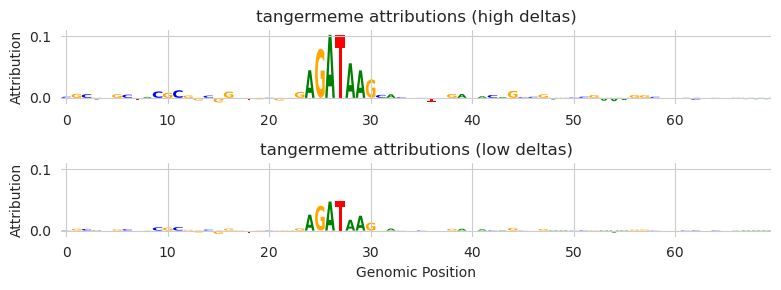

In [18]:
plt.figure(figsize=(8, 3))
ax = plt.subplot(211)
plt.title("tangermeme attributions (high deltas)")
plot_logo(X_attr_t1[0], ax=ax, start=1030, end=1100)
plt.ylim(-0.01, 0.11)
plt.ylabel("Attribution")

ax = plt.subplot(212)
plt.title("tangermeme attributions (low deltas)")
plot_logo(X_attr_t2[0], ax=ax, start=1030, end=1100)
plt.ylim(-0.01, 0.11)
plt.xlabel("Genomic Position")
plt.ylabel("Attribution")

plt.tight_layout()
plt.show()

At first, this may look like it is not that big a difference. When the deltas are low basically the same motif is highlighted as when the deltas are high. However, the attribution values themselves are much lower. This is because, when the deltas are high, the attributions can highlight motifs with a weight that is not representative of the actual prediction from the model. That is definitionally what is happening -- because the attributions must sum to the difference in predictions, having high deltas mean that the attributions are either incorrectly high or low. It does *not* mean that the attributions will be entirely noise or garbage-looking. This is a big misconception that can lead you to think that your attributions are accurate because you're seeing motif-looking things being highlighted.

As an example of this, let's consider a weaker version of the GATA motif that is just the `GATAA` nucleotides without the flanking sequence. 

/users/jmschr/github/tangermeme/tangermeme/deep_lift_shap.py:436: RuntimeWarning: Convergence deltas too high: tensor([0.8181, 0.8875, 0.7360, 0.8311, 0.6618, 0.6119, 0.7428, 0.7098, 0.6563,
        0.8499, 0.6622, 1.0616, 0.7825, 0.6159, 0.6683, 0.6716, 0.6975, 0.7672,
        0.6076, 0.7170], grad_fn=<AbsBackward0>)
  warnings.warn("Convergence deltas too high: " +


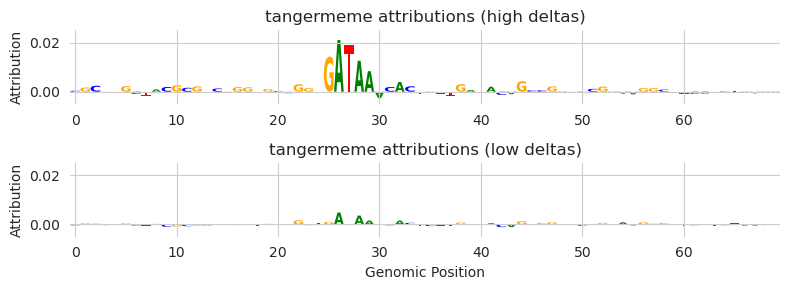

In [19]:
X2 = random_one_hot((1, 4, 2114), random_state=0).type(torch.float32)
X2 = substitute(X2, "GATAA")
X2_ref = dinucleotide_shuffle(X2, n=20, random_state=0)

X2_attr_t1 = deep_lift_shap(wrapper_profile, X2, references=X2_ref, device='cpu')
X2_attr_t2 = deep_lift_shap(wrapper_profile, X2, additional_nonlinear_ops={_ProfileLogitScaling: _nonlinear}, 
    references=X2_ref, device='cpu')

plt.figure(figsize=(8, 3))
ax = plt.subplot(211)
plt.title("tangermeme attributions (high deltas)")
plot_logo(X2_attr_t1[0], ax=ax, start=1030, end=1100)
plt.ylim(-0.005, 0.025)
plt.ylabel("Attribution")

ax = plt.subplot(212)
plt.title("tangermeme attributions (low deltas)")
plot_logo(X2_attr_t2[0], ax=ax, start=1030, end=1100)
plt.ylim(-0.005, 0.025)
plt.xlabel("Genomic Position")
plt.ylabel("Attribution")

plt.tight_layout()
plt.show()

When the convergence deltas are high, we can see that the motif still seems to be highlighted (albeit as a smaller magnitude than the previous example). However, when we correct the deltas, the motif no longer appears at all. Again, the deltas suggest this is because the sum of the attribution values is higher than the difference in predicted values. We can check the predicted profiles to see whether there's a real pattern or only sort of a pattern in comparison to what it used to be.

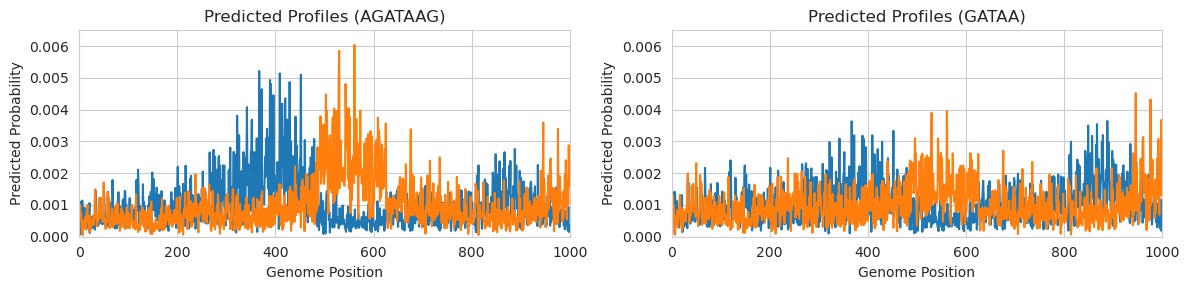

In [20]:
plt.figure(figsize=(12, 3))
plt.subplot(121)
y_ = model(X)[0]
y_ = torch.nn.functional.softmax(y_, dim=-1).numpy(force=True)
plt.title("Predicted Profiles (AGATAAG)")
plt.plot(y_[0].T)
plt.xlabel("Genome Position")
plt.ylabel("Predicted Probability")
plt.ylim(0, 0.0065)
plt.xlim(0, 1000)

plt.subplot(122)
y_ = model(X2)[0]
y_ = torch.nn.functional.softmax(y_, dim=-1).numpy(force=True)
plt.title("Predicted Profiles (GATAA)")
plt.plot(y_[0].T)
plt.xlabel("Genome Position")
plt.ylabel("Predicted Probability")
plt.ylim(0, 0.0065)
plt.xlim(0, 1000)

plt.tight_layout()
plt.show()

It looks like there is a clear predicted pattern on the left hand side with peaks on either side of the central position, as one might expect. On the right hand side there isn't much to speak of. There might be a small bump on either side there but it is difficult to tell, and if you only looked at the uncorrected attributions you might think that there is stronger binding than there actually is. This is why having correct attribution values is especially important when it comes to weak motifs.

##### Captum will fail silently

At this point, I hope the importance of making sure your convergence deltas are near zero has been made clear. But this raises the question of what happens when you try to use Captum. Does it raise a warning when the convergence deltas are too high, as they were when we tried using the profile wrapper without registering its non-linear component?

In [21]:
X_attr_c1 = DeepLiftShap(wrapper_profile).attribute(X, X_ref[0], custom_attribution_func=hypothetical_attributions).detach() * X

/users/jmschr/anaconda3/lib/python3.11/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


No. No indication that anything might be wrong. But we can confirm that we get the same attributions as tangermeme when tangermeme reports the high convergence deltas by visually inspecting the logo plots.

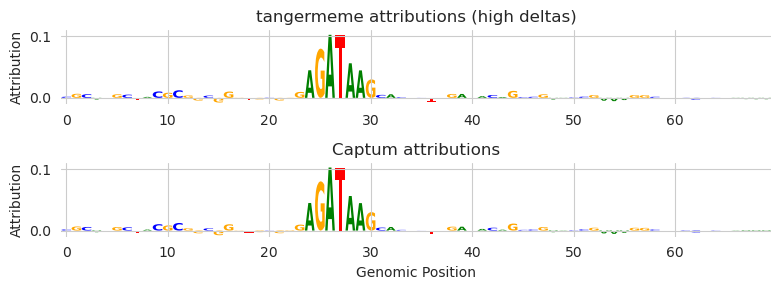

In [22]:
plt.figure(figsize=(8, 3))
ax = plt.subplot(211)
plt.title("tangermeme attributions (high deltas)")
plot_logo(X_attr_t1[0], ax=ax, start=1030, end=1100)
plt.ylim(-0.01, 0.11)
plt.ylabel("Attribution")

ax = plt.subplot(212)
plt.title("Captum attributions")
plot_logo(X_attr_c1[0], ax=ax, start=1030, end=1100)
plt.ylim(-0.01, 0.11)
plt.xlabel("Genomic Position")
plt.ylabel("Attribution")

plt.tight_layout()
plt.show()

We can use our previously described strategy for calculating the convergence deltas from Captum and compare them to the tangermeme convergence deltas when we register the `_ProfileLogitScaling` layer. 

/users/jmschr/anaconda3/lib/python3.11/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


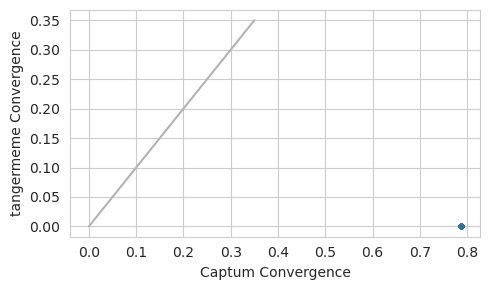

In [23]:
X_attr_t = deep_lift_shap(wrapper_profile, X, references=X_ref2, device='cpu', 
    additional_nonlinear_ops={_ProfileLogitScaling: _nonlinear}, hypothetical=True, raw_outputs=True)
X_attr_c = DeepLiftShap(wrapper_profile, multiply_by_inputs=False).attribute(X, X_ref2[0]).detach()

y_profile = wrapper_profile(X)
y_profile_ref2 = wrapper_profile(X_ref2[0])
output_diff = (y_profile - y_profile_ref2)[:, 0]

convergence_t = abs(output_diff - torch.sum(input_diff * X_attr_t[0], dim=(1, 2))).numpy(force=True)
convergence_c = abs(output_diff - torch.sum(input_diff * X_attr_c, dim=(1, 2))).numpy(force=True)

plt.figure(figsize=(5, 3))
plt.scatter(convergence_c, convergence_t, s=10)
plt.plot([0, 0.35], [0, 0.35], c='0.7')
plt.xlabel("Captum Convergence")
plt.ylabel("tangermeme Convergence")
plt.tight_layout()
plt.show()

Looks like tangermeme's convergence deltas are near zero, as you might expect after registering the non-linear component, but Captum's have silently produced attributions with large convergence deltas.

So... how do we register the non-linear component with Captum? Unfortunately, there isn't a way to pass in new layers directly into the `DeepLiftShap` object when calculating attributions. The only way I found to register new layers is to modify the dictionary that is defined in the `deep_lift.py` file several layers deep into Captum. You just need to set the layer to be Captum's version of the `_nonlinear` function.

In [24]:
import captum
from captum.attr._core.deep_lift import nonlinear as captum_nonlinear

captum.attr._core.deep_lift.SUPPORTED_NON_LINEAR[_ProfileLogitScaling] = captum_nonlinear

Once you've done this you can check to see whether the convergence deltas are smaller.

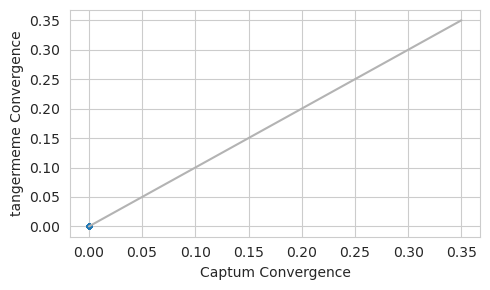

In [25]:
X_attr_t = deep_lift_shap(wrapper_profile, X, references=X_ref2, device='cpu', 
    additional_nonlinear_ops={_ProfileLogitScaling: _nonlinear}, hypothetical=True, raw_outputs=True)
X_attr_c = DeepLiftShap(wrapper_profile, multiply_by_inputs=False).attribute(X, X_ref2[0]).detach()

convergence_t = abs(output_diff - torch.sum(input_diff * X_attr_t[0], dim=(1, 2))).numpy(force=True)
convergence_c = abs(output_diff - torch.sum(input_diff * X_attr_c, dim=(1, 2))).numpy(force=True)

plt.figure(figsize=(5, 3))
plt.scatter(convergence_c, convergence_t, s=10)
plt.plot([0, 0.35], [0, 0.35], c='0.7')
plt.xlabel("Captum Convergence")
plt.ylabel("tangermeme Convergence")
plt.tight_layout()
plt.show()

Looks like after registering the layer, both are returning convergence deltas that are near zero. We can again inspect the logoplot to make sure that they're producing similar results.

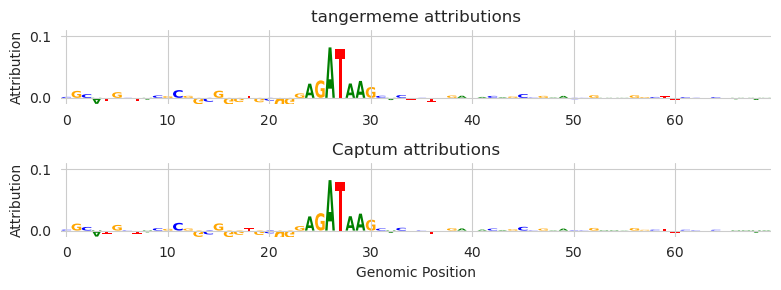

In [26]:
plt.figure(figsize=(8, 3))
ax = plt.subplot(211)
plt.title("tangermeme attributions")
plot_logo(X_attr_t[0, 0] * X[0], ax=ax, start=1030, end=1100)
plt.ylim(-0.01, 0.11)
plt.ylabel("Attribution")

ax = plt.subplot(212)
plt.title("Captum attributions")
plot_logo(X_attr_c[0] * X[0], ax=ax, start=1030, end=1100)
plt.ylim(-0.01, 0.11)
plt.ylabel("Attribution")
plt.xlabel("Genomic Position")

plt.tight_layout()
plt.show()

##### CUDA causes lower precision

Another aspect of this story is that you can get convergence deltas that are several orders of magnitude higher when using a CUDA device as when using a CPU device.

In [27]:
print("Convergence Deltas (CPU)")
X_attr_cpu = deep_lift_shap(wrapper_counts, X, references=X_ref, device='cpu', print_convergence_deltas=True)

print("\nConvergence Deltas (CUDA)")
X_attr_cuda = deep_lift_shap(wrapper_counts, X, references=X_ref, device='cuda', print_convergence_deltas=True)

Convergence Deltas (CPU)
tensor([0.0000e+00, 8.9407e-08, 1.6391e-07, 1.4901e-07, 5.9605e-08, 8.9407e-08,
        2.9802e-08, 2.9802e-08, 7.4506e-08, 5.9605e-08, 8.9407e-08, 5.9605e-08,
        1.4901e-08, 2.2352e-08, 0.0000e+00, 5.9605e-08, 5.9605e-08, 1.7881e-07,
        1.0431e-07, 5.9605e-08], grad_fn=<AbsBackward0>)

Convergence Deltas (CUDA)
tensor([2.2054e-05, 3.0011e-05, 5.1275e-05, 6.6496e-05, 6.9350e-05, 1.4126e-05,
        9.4861e-05, 1.5795e-05, 1.6034e-05, 3.7551e-05, 7.5161e-05, 8.5086e-06,
        3.3528e-05, 3.3677e-05, 2.4796e-05, 4.6194e-06, 9.1791e-06, 2.5809e-05,
        1.0885e-05, 5.2959e-05], device='cuda:0', grad_fn=<AbsBackward0>)


This doesn't seem to yield attributions that are systematically different from each other.

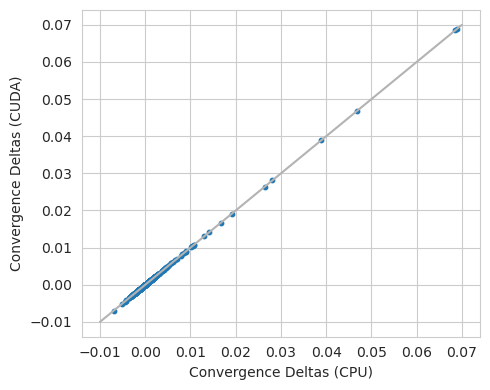

In [28]:
plt.figure(figsize=(5, 4))
plt.scatter(X_attr_cpu.flatten(), X_attr_cuda.flatten(), s=10)
plt.plot([-0.01, 0.07], [-0.01, 0.07], c='0.7')
plt.xlabel("Convergence Deltas (CPU)")
plt.ylabel("Convergence Deltas (CUDA)")
plt.tight_layout()
plt.show()

Although I am not sure *exactly* what is happening, I do know that the basic reason is related to machine precision issues. Basically, because the order of operations matters a great deal for calculating very small values, i.e., summing large arrays can be numerically unstable, and because this order of operations is changed by the computation graph when using a GPU to maximize parallelism, a consequence might be that the underlying precision is lowered a bit. 

Regardless of the exact reasons why this is, having a difference in baseline convergence deltas means that the thresholds that you set based on results from a CPU may need to be raised a bit when doing operations on the GPU. On the other hand, if you aren't sure whether your values are being driven by not having registered non-linear operations or some form of machine precision issue, it means you can check a limited set of operations on the CPU. In general, it should be obvious when a layer has not been registered because the deltas will be above 0.01 pretty routinely, whereas when it's a machine precision issue they will usually be in the 1e-3 or less (usually 1e-5, but it depends on the architecture).

##### Double precision causes... high precision

As one might expect, doing operations at higher precision can cause the convergence deltas to be lower when the values are driven by the aforementioned machine precision issues instead of the failing to register a layer. Using double precision is easy in tangermeme -- all you need to do is convert the datatypes of everything.

In [29]:
print("Convergence Deltas (CPU)")
X_attr_cpu = deep_lift_shap(wrapper_counts.double(), X.double(), references=X_ref.double(), device='cpu', print_convergence_deltas=True)

print("\nConvergence Deltas (CUDA)")
X_attr_cuda = deep_lift_shap(wrapper_counts.double(), X.double(), references=X_ref.double(), device='cuda', print_convergence_deltas=True)

Convergence Deltas (CPU)
tensor([1.1102e-16, 3.3307e-16, 3.8858e-16, 4.0246e-16, 2.7756e-16, 3.3307e-16,
        1.1102e-16, 3.3307e-16, 2.7756e-16, 2.7756e-16, 1.6653e-16, 3.3307e-16,
        3.0531e-16, 2.6368e-16, 2.7756e-16, 2.7756e-16, 4.4409e-16, 1.1102e-16,
        2.4980e-16, 3.8858e-16], dtype=torch.float64, grad_fn=<AbsBackward0>)

Convergence Deltas (CUDA)
tensor([3.3307e-16, 3.3307e-16, 2.7756e-16, 2.3592e-16, 2.2204e-16, 2.2204e-16,
        1.1102e-16, 1.1102e-16, 3.3307e-16, 1.6653e-16, 2.7756e-16, 2.2204e-16,
        3.0531e-16, 3.3307e-16, 2.2204e-16, 1.1102e-16, 3.3307e-16, 1.1102e-16,
        0.0000e+00, 3.3307e-16], device='cuda:0', dtype=torch.float64,
       grad_fn=<AbsBackward0>)


Looks like the convergence deltas are back to being around as low as they are on the CPU. Calculating attributions using 64-bit floats can take quite a bit longer than 32-bit floats because each number is twice as long but also because hardware is generally more optimized for 32-bit and 16-bit floats than they are for 64-bit ones.

##### Summary

DeepLiftShap requiring that gradient operations for non-linear operations are overriden results in several practical implementation challenges. Unfortunately, these challenges have not always been appreciated by the developers and the lack of errors or warnings being raised when something is wrong has almost certainly led users to incorrectly calculate attributions in the past. I hope that the safeguards implemented in tangermeme, as well as write-ups like this one, help the community calculate attributions correctly and seek help when something is going wrong.